In [1]:
#作业要求： 接触adversarial attack 一个简单的 attack approach: FGSM
#代码中所用到的资源需自行提前下载

In [2]:
#引入库
import os
# 读取 label.csv
import pandas as pd
# 读取图片
from PIL import Image
# 支持大量的维度数组和矩阵运算
import numpy as np

import torch
# Loss function
import torch.nn.functional as F
# 读取资料
import torchvision.datasets as datasets
# 主要用来将自定义的数据读取接口的输出或者pytorch已有的数据读取接口的输入按照batch_size封装成Tensor
from torch.utils.data import Dataset, DataLoader
# 载入预训练模型
import torchvision.models as models
# 将资料装换成符合预训练模型的形式
import torchvision.transforms as transforms
# 显示图片
import matplotlib.pyplot as plt

# 表示将torch.Tensor分配到的设备的对象为cuda
device = torch.device("cuda")

In [3]:
# 读取资料库
# 實作一個繼承 torch.utils.data.Dataset 的 Class 來讀取圖片
class Adverdataset(Dataset):
    def __init__(self, root, label, transforms):


        # 圖片所在的資料夾
        self.root = root
        # 由 main function 傳入的 label
        self.label = torch.from_numpy(label).long()
        # 由 Attacker 傳入的 transforms 將輸入的圖片轉換成符合預訓練模型的形式
        self.transforms = transforms
        # 圖片檔案名稱的 list
        self.fnames = []

        # 主要实现图片名称若列宽不足3位，则用数字0填充到3位
        for i in range(200):
            self.fnames.append("{:03d}".format(i))

    def __getitem__(self, idx):
        # 利用路徑讀取圖片
        img = Image.open(os.path.join(self.root, self.fnames[idx] + '.png'))
        # 將輸入的圖片轉換成符合預訓練模型的形式
        img = self.transforms(img)
        # 圖片相對應的 label
        label = self.label[idx]
        return img, label
    
    def __len__(self):
        # 由於已知這次的資料總共有 200 張圖片 所以回傳 200
        return 200

In [4]:
# 载入模型并执行FGSM攻击
class Attacker:
    def __init__(self, img_dir, label):
        # 讀入預訓練模型 vgg16
        self.model = models.vgg16(pretrained = True)
        # 模型将在GPU上运行
        self.model.cuda()
        # 固定BatchNoramalization 和 Dropout 层,使得偏置参数不随着发生变化
        self.model.eval()
        # 使用imagenet 的平均值和标准差进行正则化
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        # 把圖片 normalize 到 0~1 之間 mean 0 variance 1
        self.normalize = transforms.Normalize(self.mean, self.std, inplace=False)
        transform = transforms.Compose([                
                        transforms.Resize((224, 224), interpolation=3),
                        transforms.ToTensor(),
                        self.normalize
                    ])
        
        # 利用 Adverdataset 這個 class 讀取資料，将标签值和训练值给dataset
        self.dataset = Adverdataset('./data/images', label, transform)
        
        # __init__中的几个重要的输入：1、dataset，这个就是PyTorch已有的数据读取接口
        #（比如torchvision.datasets.ImageFolder）或者自定义的数据接口的输出，
        # 该输出要么是torch.utils.data.Dataset类的对象，要么是继承自torch.utils.data.Dataset类的自定义类的对象。
        # 2、batch_size，根据具体情况设置即可。3、shuffle(打乱数据)，一般在训练数据中会采用
        self.loader = torch.utils.data.DataLoader(
                self.dataset,
                batch_size = 1,
                shuffle = False)
        

    # FGSM 攻擊
    def fgsm_attack(self, image, epsilon, data_grad):#epsilon是后面自己设置数，体现噪声的强度

        # 找出 gradient 的方向
        sign_data_grad = data_grad.sign()
        # 將圖片加上 gradient 方向乘上 epsilon 的 noise
        perturbed_image = image + epsilon * sign_data_grad#生成有噪音的图片
        return perturbed_image
    
    def attack(self, epsilon):

        # 存下一些成功攻擊後的圖片 以便之後顯示
        adv_examples = []
        wrong, fail, success = 0, 0, 0
        for (data, target) in self.loader:
            data, target = data.to(device), target.to(device)#把数据转化为cpu,或者GPU的数据类型
            data_raw = data;
            data.requires_grad = True#自动计算梯度

            # 將圖片丟入 model 進行測試 得出相對應的 class
            output = self.model(data)
            init_pred = output.max(1, keepdim=True)[1]

            # 如果 class 錯誤 就不進行攻擊
            if init_pred.item() != target.item():
                wrong += 1
                continue
            
            # 如果 class 正確 就開始計算 gradient 進行 FGSM 攻擊
            loss = F.nll_loss(output, target)
            self.model.zero_grad()#梯度置零，防止叠加
            loss.backward()
            data_grad = data.grad.data
            perturbed_data = self.fgsm_attack(data, epsilon, data_grad)

            # 再將加入 noise 的圖片丟入 model 進行測試 得出相對應的 class        
            output = self.model(perturbed_data)
            final_pred = output.max(1, keepdim=True)[1]
          
            if final_pred.item() == target.item():
                # 辨識結果還是正確 攻擊失敗
                fail += 1
            else:
                # 辨識結果失敗 攻擊成功
                success += 1
                # 將攻擊成功的圖片存入
                if len(adv_examples) < 5:
                  adv_ex = perturbed_data * torch.tensor(self.std, device = device).view(3, 1, 1) + torch.tensor(self.mean, device = device).view(3, 1, 1)
                  adv_ex = adv_ex.squeeze().detach().cpu().numpy() 
                  #squeeze 数据的维度进行压缩，去掉维数为1的的维度，比如是一行或者一列这种，一个一行三列（1,3）的数去掉第一个维数为一的维度之后就变成（3）行
                  data_raw = data_raw * torch.tensor(self.std, device = device).view(3, 1, 1) + torch.tensor(self.mean, device = device).view(3, 1, 1)
                  data_raw = data_raw.squeeze().detach().cpu().numpy()
                  adv_examples.append( (init_pred.item(), final_pred.item(), data_raw , adv_ex) )        
        final_acc = (fail / (wrong + success + fail))
        
        print("Epsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon, fail, len(self.loader), final_acc))
        return adv_examples, final_acc

In [5]:
# 执行攻击 并显示攻击成功率
if __name__ == '__main__':
    # 讀入圖片相對應的 label
    df = pd.read_csv("./data/labels.csv")
    df = df.loc[:, 'TrueLabel'].to_numpy()
    label_name = pd.read_csv("./data/categories.csv")
    label_name = label_name.loc[:, 'CategoryName'].to_numpy()
    # new 一個 Attacker class
    attacker = Attacker('./data/images', df)
    # 要嘗試的 epsilon
    epsilons = [0.1, 0.01]

    accuracies, examples = [], []

    # 進行攻擊 並存起正確率和攻擊成功的圖片
    for eps in epsilons:
        ex, acc = attacker.attack(eps)
        accuracies.append(acc)
        examples.append(ex)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Epsilon: 0.1	Test Accuracy = 7 / 200 = 0.035

Epsilon: 0.01	Test Accuracy = 54 / 200 = 0.27



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


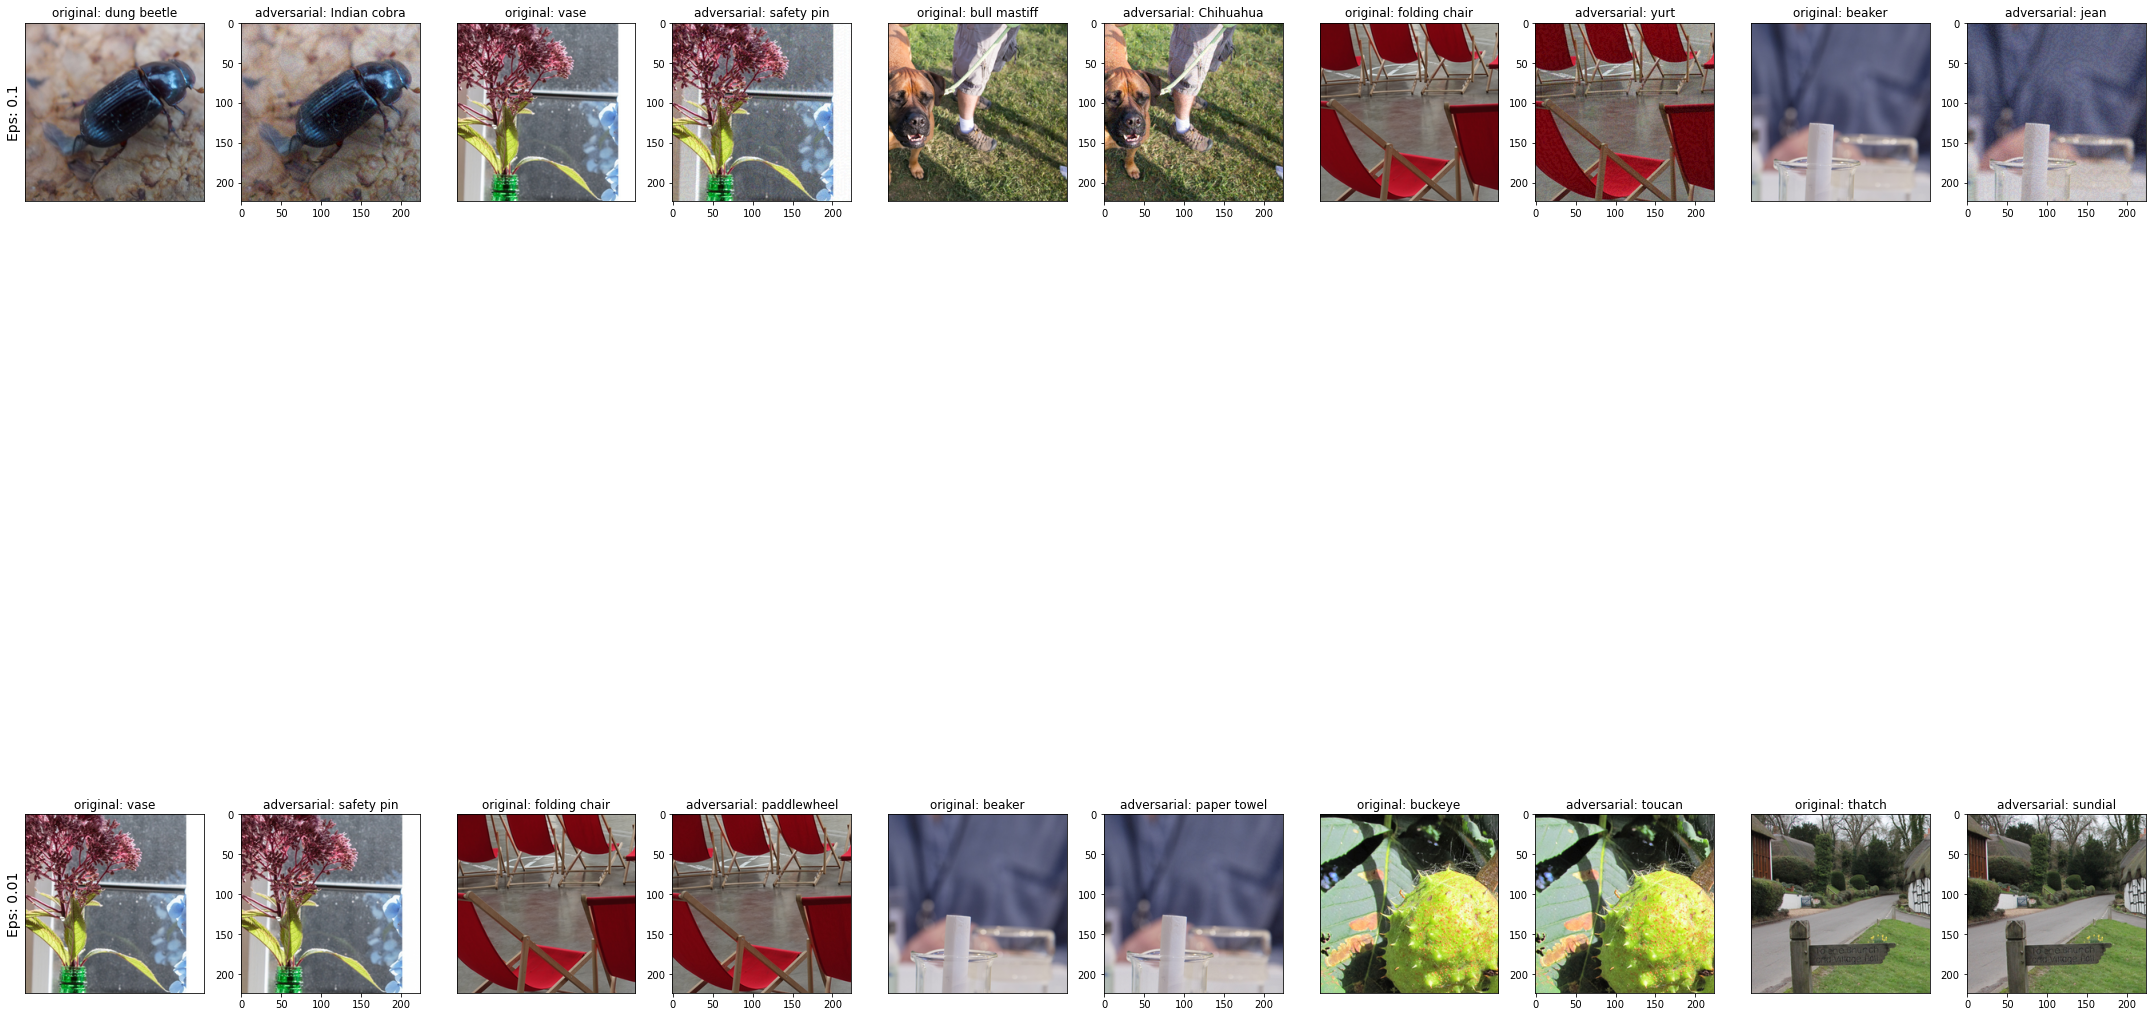

In [6]:
# 显示FGSM产生的图片
cnt = 0
plt.figure(figsize=(30, 30))
for i in range(len(epsilons)):#遍历之前eps里的元素，idx值为0，1

    for j in range(len(examples[i])):#遍历样本值，
        cnt += 1

        #subplot(nrows, ncols, plot_number)
        #或者写成subplot(nrows ncols plot_number)也行（中间不用逗号，前提是只能是三位数）
        #这个函数用来表示把figure分成nrows*ncols的子图表示，
        #nrows：子图的行数
        #ncols：子图的列数
        #plot_number 索引值，表示把图画在第plot_number个位置（从左下角到右上角）
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.xticks([], [])#坐标轴变名用法
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)

        orig,adv,orig_img, ex = examples[i][j]

        # plt.title("{} -> {}".format(orig, adv))
        plt.title("original: {}".format(label_name[orig].split(',')[0]))
        orig_img = np.transpose(orig_img, (1, 2, 0))#转置(0,1,2)->(1, 2, 0)
        plt.imshow(orig_img)
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.title("adversarial: {}".format(label_name[adv].split(',')[0]))
        ex = np.transpose(ex, (1, 2, 0))
        plt.imshow(ex)
plt.tight_layout()
plt.show()